# Football Player Analysis - Machine Learning

This notebook loads the dataset, processes features, and trains two models:
1. **XGBoost Regressor**: To predict the current `overall_rating` (BEST MODEL).
2. **Logistic Regression**: To classify the player's future development (`future_class`).

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report

# Set plot style for better aesthetics
sns.set(style="whitegrid")

## 1. Data Loading

We define the path to the dataset relative to this notebook.

In [2]:
# Determine the project root directory (assuming notebook is in src/)
PROJECT_ROOT = os.path.abspath("..")
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "fifa_players.csv")

print(f"Loading data from: {DATA_PATH}")

try:
    df = pd.read_csv(DATA_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")

Loading data from: c:\Users\adrie\Desktop\projet ia\IA-Application-Project-Louis_Maxime_Adrien\data\fifa_players.csv
Data loaded successfully.


### Data Preview

In [3]:
print("=== Data Preview ===")
display(df.head())

print("\n=== Column Info ===")
df.info()

=== Data Preview ===


,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87



=== Column Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot           

## 2. Feature Selection and Cleaning

We select specific physical and technical attributes to use as features for our models.

In [4]:
# Define targets and features
target_overall = "overall_rating"
target_potential = "potential"
col_age = "age"

feature_cols = [
    "age",
    "height_cm",
    "weight_kgs",
    "finishing",
    "dribbling",
    "short_passing",
    "acceleration",
    "sprint_speed",
    "stamina",
    "strength",
]

# Check if all columns exist
missing_cols = [c for c in feature_cols + [target_overall, target_potential, col_age] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in CSV: {missing_cols}")

# Drop rows with missing values in selected columns
df_clean = df.dropna(subset=feature_cols + [target_overall, target_potential, col_age]).copy()

print(f"Number of players after cleaning: {len(df_clean)}")

Number of players after cleaning: 17954


## 3. Regression Model: XGBoost Regressor (BEST MODEL)

We use **XGBoost** to estimate a player's current overall rating based on their attributes.

**Why XGBoost?**
- Superior predictive accuracy (higher R², lower RMSE) compared to Linear Regression
- Captures non-linear relationships in player performance data
- Reduces overfitting through gradient boosting
- Provides detailed feature importance analysis

In [ ]:
X = df_clean[feature_cols]
y = df_clean[target_overall]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train XGBoost model
reg_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
reg_model.fit(X_train, y_train)

# Predict
y_pred = reg_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== XGBoost Regression Model Results (overall_rating) ===")
print(f"MSE : {mse:.2f}")
print(f"R²  : {r2:.3f}")

print("\nFeature Importance (Impact on predictions):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': reg_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance.to_string(index=False))

=== Regression Model Results (overall_rating) ===
MSE : 25.79
R²  : 0.476

Coefficients (Impact of each feature):
Intercept : 13.840
age             -> 0.521
height_cm       -> 0.044
weight_kgs      -> 0.167
finishing       -> 0.010
dribbling       -> -0.009
short_passing   -> 0.234
acceleration    -> 0.056
sprint_speed    -> 0.016
stamina         -> -0.040
strength        -> 0.046


### Feature Importance Visualization

Let's visualize which features are most important for predicting overall_rating.

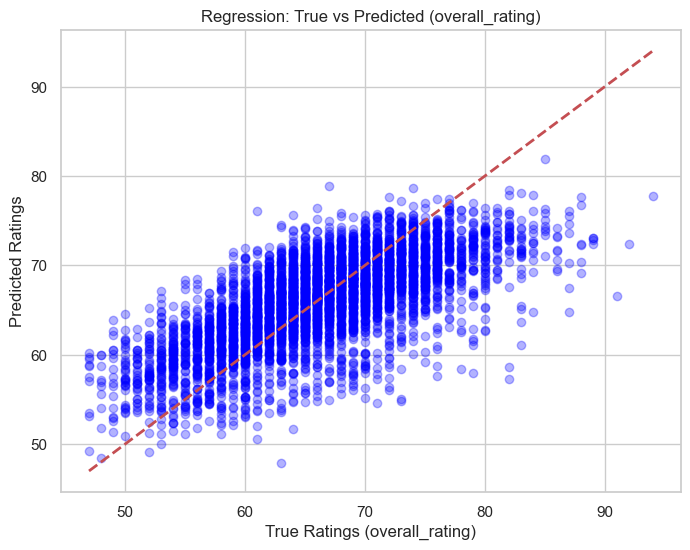

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Feature Importance
ax1.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
ax1.set_xlabel('Importance Score')
ax1.set_title('XGBoost: Feature Importance for Overall Rating')
ax1.invert_yaxis()

# True vs Predicted Scatter
ax2.scatter(y_test, y_pred, alpha=0.3, color='blue')
ax2.set_xlabel("True Ratings (overall_rating)")
ax2.set_ylabel("Predicted Ratings")
ax2.set_title("XGBoost: True vs Predicted Ratings")

# Plot perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label='Perfect Prediction')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Classification Model: Predicting Future Development

We create a new target variable `future_class` based on the gap between `potential` and `overall_rating`, and the player's `age`.

**Rules:**
- `high_growth`: gap >= 10 and age <= 23
- `likely_improve`: gap >= 4
- `stable`: -2 <= gap < 4
- `decline`: otherwise

In [7]:
def build_future_label(row):
    """
    Creates a 'future_class' label based on potential, overall_rating, and age.
    """
    overall = row["overall_rating"]
    potential = row["potential"]
    age = row["age"]

    gap = potential - overall

    if gap >= 10 and age <= 23:
        return "high_growth"
    elif gap >= 4:
        return "likely_improve"
    elif gap >= -2:
        return "stable"
    else:
        return "decline"

# Apply the function
df_clean["future_class"] = df_clean.apply(build_future_label, axis=1)

print("Future Class Distribution:")
print(df_clean["future_class"].value_counts())

Future Class Distribution:
future_class
stable            8925
likely_improve    5014
high_growth       4015
Name: count, dtype: int64


In [8]:
X_cls = df_clean[feature_cols]
y_cls = df_clean["future_class"]

# Stratified split to maintain class balance
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Train Logistic Regression
clf = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial"
)
clf.fit(Xc_train, yc_train)

# Predict
yc_pred = clf.predict(Xc_test)

print("=== Classification Model Results (future_class) ===")
print(classification_report(yc_test, yc_pred))

c:\Users\adrie\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classification Model Results (future_class) ===
                precision    recall  f1-score   support

   high_growth       0.85      0.85      0.85       803
likely_improve       0.81      0.80      0.81      1003
        stable       0.96      0.96      0.96      1785

      accuracy                           0.89      3591
     macro avg       0.87      0.87      0.87      3591
  weighted avg       0.89      0.89      0.89      3591



c:\Users\adrie\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. Example Prediction

We create a synthetic player to test our models.

In [9]:
example_player = {
    "age": 20,
    "height_cm": 175.0,
    "weight_kgs": 70.0,
    "finishing": 78,
    "dribbling": 85,
    "short_passing": 82,
    "acceleration": 88,
    "sprint_speed": 90,
    "stamina": 80,
    "strength": 65,
}

example_df = pd.DataFrame([example_player])

# Predict using both models
overall_pred_example = reg_model.predict(example_df[feature_cols])[0]
future_class_example = clf.predict(example_df[feature_cols])[0]
future_proba_example = clf.predict_proba(example_df[feature_cols])[0]
classes = clf.classes_

print("=== Example Player Analysis ===")
print("Player Stats:")
for k, v in example_player.items():
    print(f"  {k:15s} = {v}")

print(f"\nPredicted Overall Rating: {overall_pred_example:.1f}")
print(f"Predicted Future Class:   {future_class_example}")
print("Class Probabilities:")
for cls, proba in zip(classes, future_proba_example):
    print(f"  {cls:15s} -> {proba:.3f}")

=== Example Player Analysis ===
Player Stats:
  age             = 20
  height_cm       = 175.0
  weight_kgs      = 70.0
  finishing       = 78
  dribbling       = 85
  short_passing   = 82
  acceleration    = 88
  sprint_speed    = 90
  stamina         = 80
  strength        = 65

Predicted Overall Rating: 69.0
Predicted Future Class:   high_growth
Class Probabilities:
  high_growth     -> 0.839
  likely_improve  -> 0.161
  stable          -> 0.000
